In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys
import os
#sys.path.append('/Users/ff/dev/MSc/CX_Path_Integration')
#os.chdir('/Users/ff/dev/MSc/CX_Path_Integration/notebooks')

print(sys.path)


['/afs/inf.ed.ac.uk/user/s15/s1556895/MSc/CX_Path_Integration/notebooks', '/afs/inf.ed.ac.uk/user/s15/s1556895/miniconda3/envs/py_msc/lib/python38.zip', '/afs/inf.ed.ac.uk/user/s15/s1556895/miniconda3/envs/py_msc/lib/python3.8', '/afs/inf.ed.ac.uk/user/s15/s1556895/miniconda3/envs/py_msc/lib/python3.8/lib-dynload', '', '/afs/inf.ed.ac.uk/user/s15/s1556895/miniconda3/envs/py_msc/lib/python3.8/site-packages', '/afs/inf.ed.ac.uk/user/s15/s1556895/miniconda3/envs/py_msc/lib/python3.8/site-packages/IPython/extensions', '/afs/inf.ed.ac.uk/user/s15/s1556895/.ipython']


In [2]:
from brian2 import *
from brian2tools import *

import matplotlib.pyplot as plt

import cx_rate
import trials
import plotter

import cx_spiking.plotting
import cx_spiking.inputs
import cx_spiking.optimisation.metric

ModuleNotFoundError: No module named 'cx_rate'

In [3]:
# Constants
N_TL2 = 16
N_CL1 = 16
N_TB1 = 8
N_TN2 = 2

In [4]:
route_file = 'data/route.npz'
T_outbound = 1500

h, v, = cx_spiking.inputs.generate_route(T_outbound=T_outbound, vary_speed=True, route_file=route_file, load_route=True)

cx_spiking.inputs.save_route(route_file, h, v, save_route=True)

# Convert headings
headings, digitized = cx_spiking.inputs.compute_headings(h, N=N_TL2//2, vmin=5, vmax=100)
headings = np.tile(headings, 2)

# Convert velocity into optical flow
flow = cx_spiking.inputs.compute_flow(h, v, baseline=50, vmin=0, vmax=50)

Load route from data/route.npz
data/route.npz exists - not overwriting it


In [5]:
noise = 0.1
cx = cx_rate.CXRatePontin(noise=noise)

h, v, log, cpu4_snapshot = trials.run_trial(logging=True,
                                            T_outbound=T_outbound,
                                            T_inbound=0,
                                            noise=noise,
                                            cx=cx,
                                            route=(h[:T_outbound], v[:T_outbound]))

In [25]:
start_scope()
#defaultclock.dt = 0.05*ms

time_step = 20 # ms

recorded_spike_rates = 90 # Hz
ratio = recorded_spike_rates / (time_step * 1./1000)
print(f'ratio {ratio} - dt {defaultclock.dt}')

ratio 4500.0 - dt 0.0001


In [26]:
# transpose since log is neuron_index*time_step but we want the opposite
TL2_stimulus = TimedArray(100*log.tl2.T*Hz, dt=1.*time_step*ms)
P_TL2 = PoissonGroup(N_TL2, rates='TL2_stimulus(t,i)')
SPM_TL2_IDEAL = SpikeMonitor(P_TL2)

In [27]:
%%time
run(T_outbound*time_step*ms)

WARNING    "i" is an internal variable of group "poissongroup", but also exists in the run namespace with the value 1. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


CPU times: user 8.12 s, sys: 189 ms, total: 8.31 s
Wall time: 8.3 s


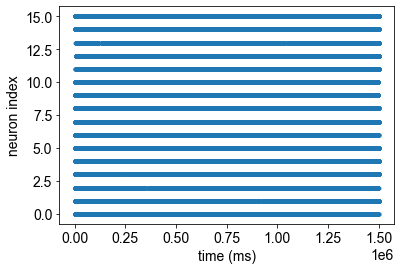

In [18]:
brian_plot(SPM_TL2_IDEAL)

In [19]:
TL2_IDEAL_spikes = cx_spiking.inputs.get_spikes_rates(SPM_TL2_IDEAL, N_TL2, T_outbound, time_step)

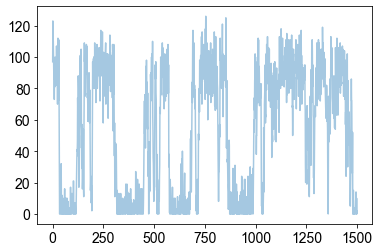

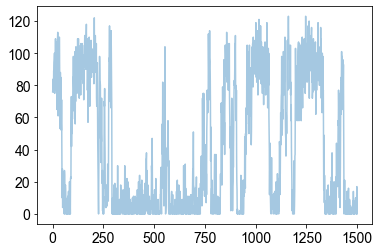

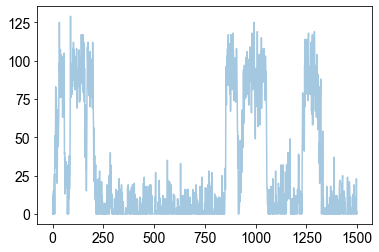

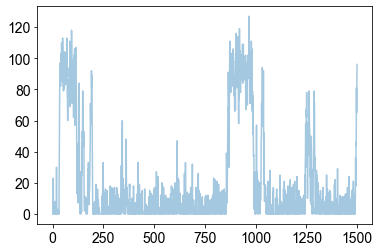

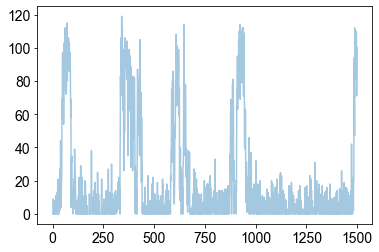

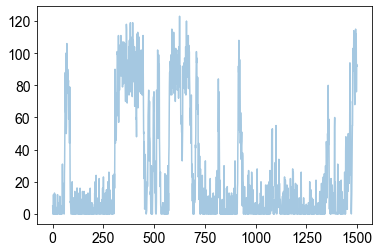

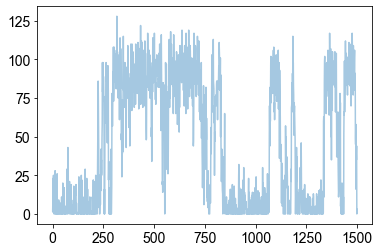

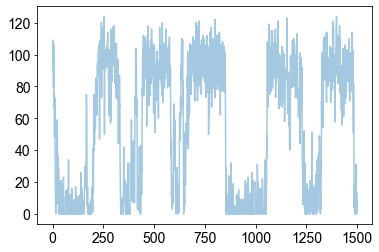

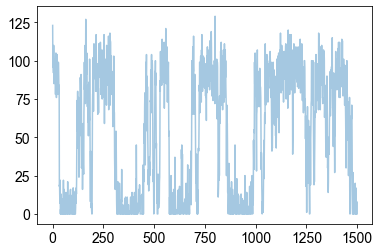

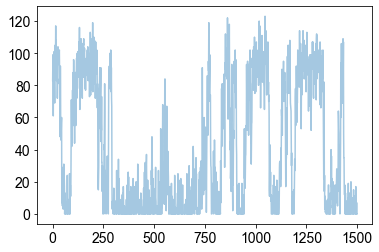

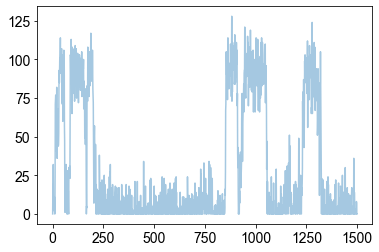

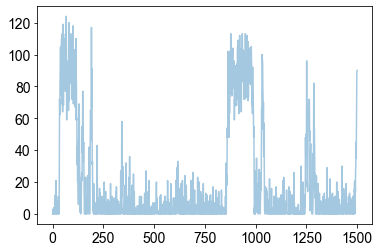

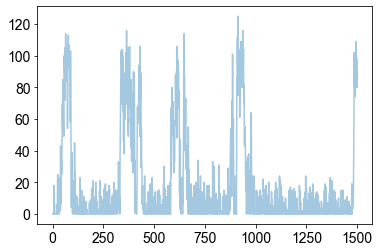

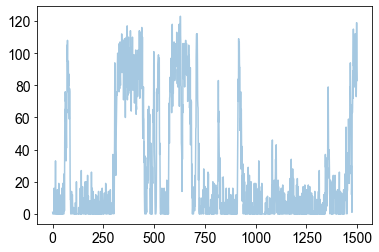

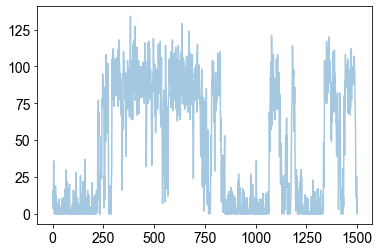

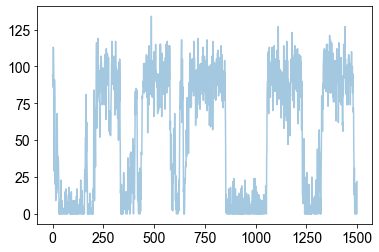

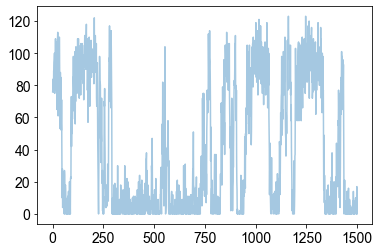

In [20]:
for n in range(N_TL2):
    plt.plot(TL2_IDEAL_spikes[n,:], alpha=0.4)
    plt.show()
plt.show()
plt.plot(TL2_IDEAL_spikes[1,:], alpha=0.4)
plt.show()

In [21]:
spikes_t = SPM_TL2_IDEAL.t/ms
spikes_i = SPM_TL2_IDEAL.i

spikes_out = np.zeros((N_TL2, T_outbound))
bins = np.arange(0, (T_outbound+1)*time_step, time_step)

[ 2.8  1.2 19.5  5.3 26.   1.5  3.3  7.1 38.1 15.9 19.9  4.2 11.1  0.9
 17.6  2.2  0.3  2.5 10.6  1.5  8.3  0.1 12.3 30.2 29.4  0.9  0.4 13.6
  1.5  3.   5.3 55.7 31.   2.4 20.9  4.2 17.9 16.2  3.6  3.9 10.4  2.4
  7.1 14.1  0.1 29.4  3.4 31.4 10.2 21.4  4.7  0.8  1.2  4.4  8.   1.8
 15.6  0.1  1.7  0.5  1.8 17.2  8.6  0.2  4.1  2.9  0.9 21.6 12.1  5.4
  0.9  3.6  4.   7.1 51.4 26.5 11.5  6.2 13.5 10.3  8.4  2.5  0.7  6.3
  2.7  1.8  3.6  7.2  6.7 15.1  5.5  2.  31.6  7.3  1.2 15.1 31.  13.2
  0.2  1.9]
[20.5  5.   2.8  2.  11.4  6.4  3.6  4.2  2.4 17.1 28.   3.9 20.2 20.1
 13.2  3.7 46.5  6.6 22.2 77.8 11.5 26.   0.8  0.6  7.7  0.6  3.1  5.3
 15.9 19.  10.2 56.  20.4 17.1  5.1  2.2  3.   5.1  4.1  5.4 16.5 21.7
 31.  17.6  5.  29.2  0.1 19.6 12.6  0.8  3.8  1.9 15.7 23.2 24.4 14.6
 37.3  5.1  8.7 16.3  0.5  8.7  0.2  8.2  1.9 10.  12.5 21.1 16.4 13.8
 10.2 15.6 16.6  2.2 10.2 11.2  5.6 11.1  1.1  6.   6.9  5.3  7.8 28.6
 21.3 48.1 31.   1.7  0.7  0.8  4.4  9.1  0.1 22.2  6.6  5.4  2.3

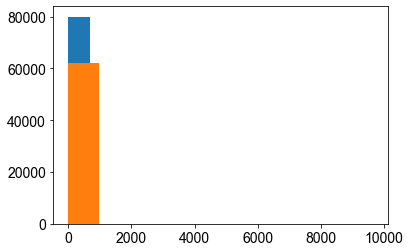

In [24]:
for i in range(2):
    spikes = spikes_t[spikes_i == i]
    spikes_count = np.diff(spikes)
    print(spikes_count[0:100])
    plt.hist(spikes_count)